# Задача 4. Ансамбли

- Найти данные размера хотя бы 10000, на которых можно решить задачу классификации или регрессии.
- Выполнить разведочный анализ (**EDA**). При необходимости выполнить полезные преобразования данных.
- Самостоятельно реализуйте алгоритмы **Bagging** и **AdaBoost**, которые позволят обучить ансамбли каких-то простых моделей, например деревьев принятия решений.
- Обучите ансамбли для каких-то простых моделей, используя свои две реализации, а также реализации из **sklearn** (**Bagging**, **Random Forest**, **AdaBoost**, **Gradient Tree Boosting**, **Histogram-Based Gradient Boosting**).
- При обучении использовать **подбор гиперпараметров**, **кросс-валидацию**.
- Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества, построить матрицы ошибок.
- (**+2 балла**) Также добавить в сравнение модели из библиотек **XGBoost**, **LightGBM** и **CatBoost**.
- (**+3 балла**) Для подбора гиперпараметров использовать фреймворк **Optuna**.

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import pathlib
import sklearn

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaseEnsemble
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder


In [89]:
%matplotlib inline
%precision %.4f

'%.4f'

In [90]:
import logging
logging.getLogger().setLevel(logging.CRITICAL)

import optuna.logging as logging
logging.set_verbosity(logging.WARNING)


import warnings
warnings.filterwarnings('ignore')

# Датасет
Для решения задачи регрессии будет использована вырезка из [датасета](https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction), который описывает информацию об авиарейсах и сопоставляет им цену. 

Нецелевые атрибуты:
  - airline: название авиакомпании
  - flight: код полёта
  - source_city: город отправления
  - departure_time: время отправления
  - stops: количество остановок
  - arrival_time: время прибытия
  - destination_city: город отправления
  - class: класс места (бизнес или эконом)
  - duration: длительность полёта
  - days_left: количество дней до полёта

Целевой атрибут
  - price: цена на билет

In [91]:
df = pd.read_csv("../datasets/flight_price.csv")
df = df.sample(20000)

In [92]:
df.head()

,no,noairline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
27131,27131,Air_India,AI-506,Delhi,Morning,one,Early_Morning,Kolkata,Economy,19.75,40,7366
266857,266857,Vistara,UK-706,Kolkata,Morning,one,Night,Mumbai,Business,9.83,42,64831
141228,141228,Vistara,UK-772,Kolkata,Morning,one,Night,Bangalore,Economy,10.50,41,6195
288329,288329,Vistara,UK-824,Chennai,Night,one,Morning,Delhi,Business,14.50,14,60160
97334,97334,Air_India,AI-501,Bangalore,Afternoon,one,Night,Mumbai,Economy,8.25,20,6578


In [93]:
df.shape

(20000, 12)

# EDA

Убедимся, что нулевых (пропущенных) значений нет

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 27131 to 260931
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   no                20000 non-null  int64  
 1   noairline         20000 non-null  object 
 2   flight            20000 non-null  object 
 3   source_city       20000 non-null  object 
 4   departure_time    20000 non-null  object 
 5   stops             20000 non-null  object 
 6   arrival_time      20000 non-null  object 
 7   destination_city  20000 non-null  object 
 8   class             20000 non-null  object 
 9   duration          20000 non-null  float64
 10  days_left         20000 non-null  int64  
 11  price             20000 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 2.0+ MB


Проверим на отсутствие дубликатов

In [95]:
df.duplicated().sum()

0

Так как значение идентификатора уникально и ни на что не влияет, можем удалить данный стобец

In [96]:
df.drop(columns=['no'], inplace=True)

Приведем все данные типа object к данным типа int

In [97]:
le = LabelEncoder()
df = df.apply(lambda x: le.fit_transform(x) if x.dtype == 'object' else x)

In [98]:
df.head()

,noairline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
27131,1,591,2,4,0,1,4,1,19.75,40,7366
266857,5,1178,4,4,0,5,5,0,9.83,42,64831
141228,5,1188,4,4,0,5,0,1,10.50,41,6195
288329,5,1213,1,5,0,4,2,0,14.50,14,60160
97334,1,586,0,0,0,5,5,1,8.25,20,6578


<Axes: >

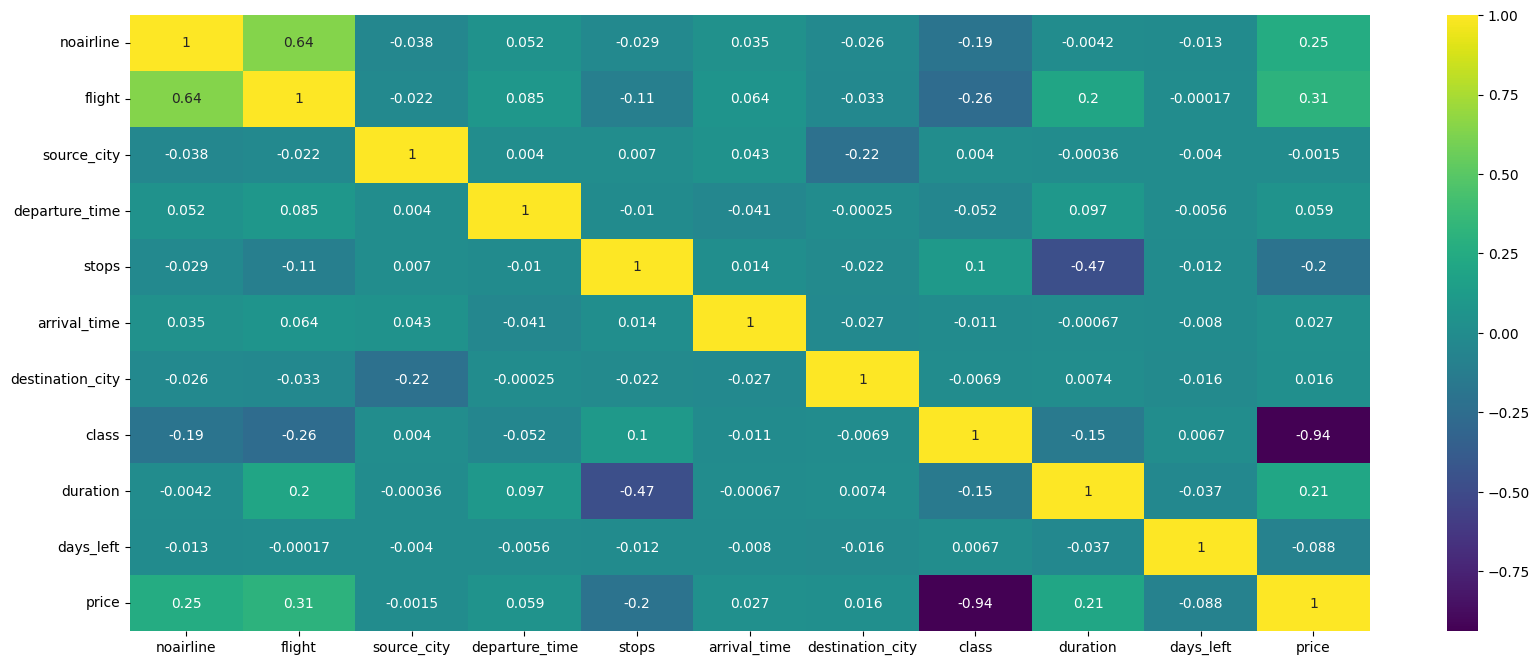

In [99]:
plt.figure(figsize=(20, 8))
sns.heatmap(df.corr(), annot=True, cmap='viridis')

Очевидна зависимость между стоимостью билета и классом полета. Кроме того, существует зависимость города отправления от цены билета, что тоже имеет смысл. Также можно заметить более слабые зависимости между количеством остановок и временем полета, а также номера полёта от авиакомпании.

# My bagging

In [100]:
np.random.seed(42)

In [101]:
class MyBagging(BaseEnsemble):
    def __init__(self, estimator=None, n_estimators=10, random_state=None):
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.random_state = random_state

    def predict(self, x):
        preds = [estimator.predict(x) for estimator in self.estimators_]
        return np.mean(preds, axis=0)

    def fit(self, x, y):
        if self.estimator is not None:
            self.estimator_ = self.estimator
        else:
            self.estimator_ = sklearn.tree.DecisionTreeRegressor()

        self.estimators_ = list()
        for _ in range(self.n_estimators):
            est = sklearn.base.clone(self.estimator_)
            x_r, y_r = sklearn.utils.resample(x, y)
            est.fit(x_r, y_r)
            self.estimators_.append(est)

# My AdaBoost

In [102]:
class MyAdaBoost(BaseEnsemble):
    def __init__(self, estimator=None, n_estimators=50, random_state=None):
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.random_state = random_state

    def predict(self, x):
        return np.around(sum((self.alphas[i] * self.estimators_[i].predict(x) for i in range(self.n_estimators))))

    def fit(self, x, y):
        if self.estimator is not None:
            self.estimator_ = self.estimator
        else:
            self.estimator_ = sklearn.tree.DecisionTreeRegressor(max_depth=3)

        self.estimators_ = list()
        self.alphas = [0 for _ in range(self.n_estimators)]
        weight = [1.0 for _ in y]

        for i in range(self.n_estimators):
            est = sklearn.base.clone(self.estimator_)
            est.fit(x, y, weight)
            error = 1 - est.score(x, y, weight)
            self.alphas[i] = np.log((1 - error) / error)
            weight = weight * np.exp(self.alphas[i] * (y != est.predict(x)))
            weight = weight / sum(weight) * len(y)
            self.estimators_.append(est)

        self.alphas /= sum(self.alphas)

# Обучение

## Оборудование

CPU 12th Gen Intel(R) Core(TM) i5-12500H

Python 3.11.4

Ubuntu 23.04

RAM 16

## Подготовка данных

In [103]:
df_data = df.drop(columns=["price"])
df_target = df["price"]

## Optuna

In [104]:
import optuna

def optuna_train(estimator, params):
    study = optuna.create_study(sampler=optuna.samplers.BruteForceSampler(seed=42), direction="maximize")
    x = df_data
    y = df_target

    model = optuna.integration.OptunaSearchCV(
        estimator,
        params,
        scoring="r2",
        n_jobs=4,
        random_state=42,
        study=study
    )

    results = sklearn.model_selection.cross_validate(
        estimator=model,
        X=x,
        y=y,
        cv=sklearn.model_selection.KFold(shuffle=True, random_state=42),
        scoring=["r2", "neg_mean_absolute_error"],
        n_jobs=4,
        return_estimator=True
    )

    for fold_i, estimator_in_fold in enumerate(results["estimator"], start=1):
        print(f"Best params #{fold_i}:", estimator_in_fold.best_params_)

    results = pd.DataFrame(results).rename(
        columns={"estimator": "Regressor",
                 "fit_time": "Fit time, s",
                 "score_time": "Score time, s",
                 "test_r2": "R2 on test"}
    )
    
    results["Regressor"] = estimator.__class__.__name__.removesuffix("Regressor")
    results["MAE on test"] = -results["test_neg_mean_absolute_error"]
    results.drop(columns=["test_neg_mean_absolute_error"], inplace=True)
    path = pathlib.Path("optuna_res.csv")
    results.to_csv(path, mode="a", header=not path.exists())

## Bagging

In [105]:
%%time

optuna_train(
    estimator=MyBagging(random_state=42),
    params={
        "n_estimators": optuna.distributions.CategoricalDistribution([10, 50, 100])
    }
)

Best params #1: {'n_estimators': 100}
Best params #2: {'n_estimators': 100}
Best params #3: {'n_estimators': 100}
Best params #4: {'n_estimators': 100}
Best params #5: {'n_estimators': 100}
CPU times: user 526 ms, sys: 337 ms, total: 864 ms
Wall time: 47.5 s


In [106]:
optuna_train(
    estimator=BaggingRegressor(random_state=42, n_jobs=4),
    params={
        "n_estimators": optuna.distributions.CategoricalDistribution([10, 50, 100])
    }
)

Best params #1: {'n_estimators': 100}
Best params #2: {'n_estimators': 100}
Best params #3: {'n_estimators': 100}
Best params #4: {'n_estimators': 100}
Best params #5: {'n_estimators': 100}


In [107]:
optuna_train(
    estimator=RandomForestRegressor(random_state=42, n_jobs=4),
    params={
        "n_estimators": optuna.distributions.CategoricalDistribution([10, 50, 100]),
    }
)

Best params #1: {'n_estimators': 100}
Best params #2: {'n_estimators': 100}
Best params #3: {'n_estimators': 100}
Best params #4: {'n_estimators': 100}
Best params #5: {'n_estimators': 100}


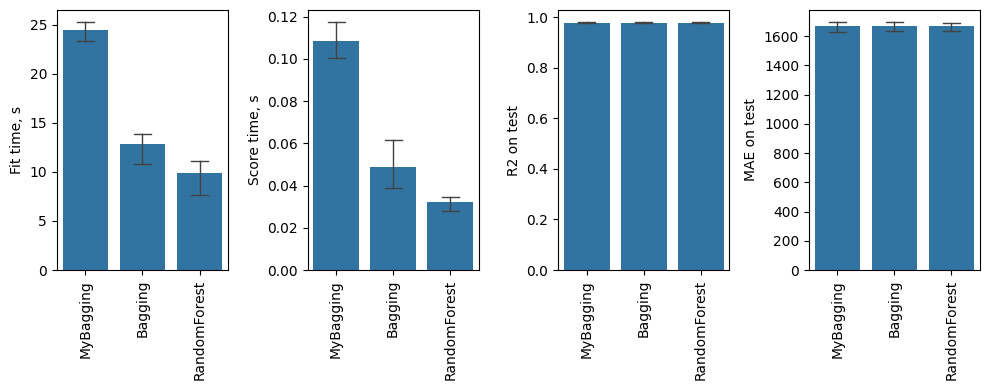

In [108]:
cv_results = pd.read_csv("optuna_res.csv")

img, axs = plt.subplots(ncols=4, figsize=(10, 4))

for y, ax in zip(["Fit time, s", "Score time, s", "R2 on test", "MAE on test"], axs.flatten()):
    sns.barplot(cv_results[["Regressor", y]], x="Regressor", y=y, errwidth=1, capsize=0.3, ax=ax)
    ax.tick_params(axis="x", rotation=90)
    ax.set_xlabel(None)

img.tight_layout()

plt.show()

## Boosting

In [109]:
optuna_train(
    estimator=MyAdaBoost(random_state=42),
    params={
        "n_estimators": optuna.distributions.CategoricalDistribution([10, 50, 100])
    }
)

Best params #1: {'n_estimators': 10}
Best params #2: {'n_estimators': 10}
Best params #3: {'n_estimators': 10}
Best params #4: {'n_estimators': 10}
Best params #5: {'n_estimators': 10}


In [110]:
optuna_train(
    estimator= AdaBoostRegressor(random_state=42),
    params={
        "n_estimators": optuna.distributions.CategoricalDistribution([10, 50, 100]),
        "learning_rate": optuna.distributions.CategoricalDistribution([0.1, 1, 2])
    }
)

Best params #1: {'n_estimators': 100, 'learning_rate': 0.1}
Best params #2: {'n_estimators': 100, 'learning_rate': 0.1}
Best params #3: {'n_estimators': 10, 'learning_rate': 1}
Best params #4: {'n_estimators': 100, 'learning_rate': 0.1}
Best params #5: {'n_estimators': 100, 'learning_rate': 0.1}


### GradientBoostingRegressor

In [111]:
optuna_train(
    estimator=GradientBoostingRegressor(random_state=42),
    params={
        "n_estimators": optuna.distributions.CategoricalDistribution([10, 50, 100]),
        "max_leaf_nodes": optuna.distributions.CategoricalDistribution([10, 1000, None]),
        "learning_rate": optuna.distributions.CategoricalDistribution([0.05, 0.1, 0.3])
    }
)

Best params #1: {'n_estimators': 50, 'max_leaf_nodes': None, 'learning_rate': 0.3}
Best params #2: {'n_estimators': 50, 'max_leaf_nodes': None, 'learning_rate': 0.3}
Best params #3: {'n_estimators': 50, 'max_leaf_nodes': None, 'learning_rate': 0.3}
Best params #4: {'n_estimators': 50, 'max_leaf_nodes': None, 'learning_rate': 0.3}
Best params #5: {'n_estimators': 50, 'max_leaf_nodes': None, 'learning_rate': 0.3}


### HistGradientBoostingRegressor

In [112]:
optuna_train(
    estimator=HistGradientBoostingRegressor(random_state=42),
    params={
        "learning_rate": optuna.distributions.CategoricalDistribution([0.05, 0.1, 0.3])
    }
)

Best params #1: {'learning_rate': 0.3}
Best params #2: {'learning_rate': 0.3}
Best params #3: {'learning_rate': 0.3}
Best params #4: {'learning_rate': 0.3}
Best params #5: {'learning_rate': 0.3}


### XGBoost

In [113]:
optuna_train(
    estimator=XGBRegressor(random_state=42, n_jobs=4),
    params={
        "n_estimators": optuna.distributions.CategoricalDistribution([100, 150, 200]),
        "learning_rate": optuna.distributions.CategoricalDistribution([0.05, 0.1, 0.3])
    }
)

Best params #1: {'n_estimators': 200, 'learning_rate': 0.3}
Best params #2: {'n_estimators': 200, 'learning_rate': 0.3}
Best params #3: {'n_estimators': 200, 'learning_rate': 0.3}
Best params #4: {'n_estimators': 200, 'learning_rate': 0.3}
Best params #5: {'n_estimators': 200, 'learning_rate': 0.3}


### LightGBM

In [114]:
optuna_train(
    estimator=LGBMRegressor(random_state=42, n_jobs=4),
    params={
        "n_estimators": optuna.distributions.CategoricalDistribution([50, 100, 150]),
        "learning_rate": optuna.distributions.CategoricalDistribution([0.05, 0.1, 0.3])
    }
)

Best params #1: {'n_estimators': 150, 'learning_rate': 0.3}
Best params #2: {'n_estimators': 150, 'learning_rate': 0.3}
Best params #3: {'n_estimators': 150, 'learning_rate': 0.3}
Best params #4: {'n_estimators': 150, 'learning_rate': 0.3}
Best params #5: {'n_estimators': 150, 'learning_rate': 0.3}


### CatBoost

In [115]:
optuna_train(
    estimator=CatBoostRegressor(random_state=42, thread_count=2),
    params={
        "n_estimators": optuna.distributions.CategoricalDistribution([50, 100, 200])
    }
)

Best params #1: {'n_estimators': 200}
Best params #2: {'n_estimators': 200}
Best params #3: {'n_estimators': 200}
Best params #4: {'n_estimators': 200}
Best params #5: {'n_estimators': 200}


# Результаты

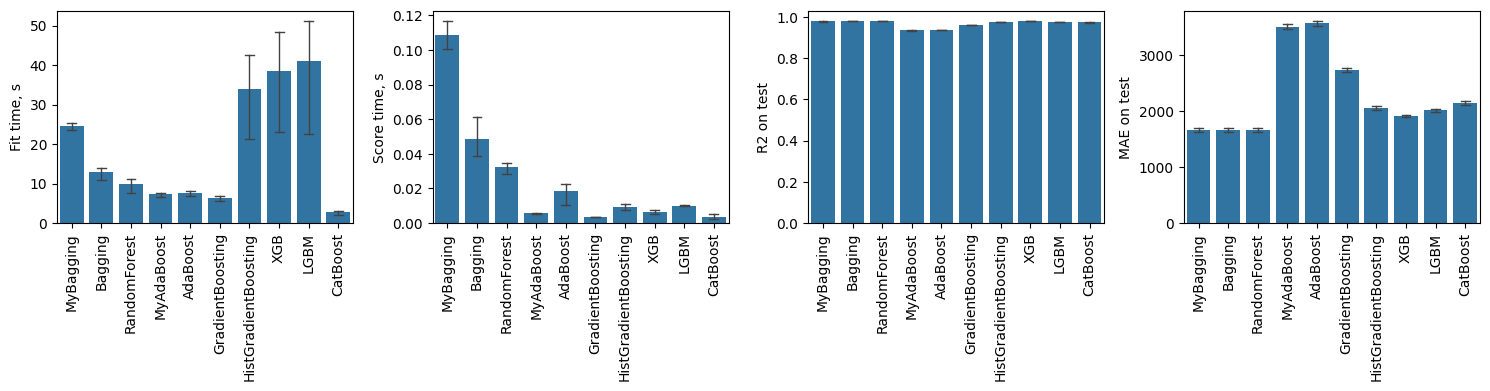

In [119]:
results = pd.read_csv("optuna_res.csv")
fig, axs = plt.subplots(ncols=4, figsize=(15, 4))

for y, ax in zip(["Fit time, s", "Score time, s", "R2 on test", "MAE on test"], axs.flatten()):
    sns.barplot(results[["Regressor", y]], x="Regressor", y=y, errwidth=1, capsize=0.3, ax=ax)
    ax.tick_params(axis="x", rotation=90)
    ax.set_xlabel(None)

fig.tight_layout()

plt.show()

## Вывод

Удаление каких-либо столбцов не привело к лучшему результату MAE. В среднем при удалении любых столбцов MAE вырастала и начиналась от двух тысяч. Скорее всего, модели надо обучать на полных 300 тысячах записей, но, к сожалению, машина автора не вывозит такой объем данных и уходит в отказ. 

Но в целом можно заметить, что модели показывают неплохой результат, и лучший показывают Bagging, MyBagging и RandomForest.